# HC-sort

**Motivation** I've been trying to understand the difference b/w the $\mathrm{\mathbb{P}}$ and the $\min \Delta R$ pairings. 

Even after 
1. Switching from `ntag` -> `ntag_pag` and 
2. Doing a SR optimization, it seemed like the naive $s / \sqrt{b}$ was better for $\min \Delta R$.

<img src="figures/data17-JUN20/preLN_lr_0p003/Xhh_scan_preXwt.pdf" width="400"/>

Note, the plot above isn't using the full NN rw, just the CR yield normalized 2b with a $2b$ derived CR $\rightarrow$ correction ratio, but I think the message that $\min \Delta R$ has a better $s/\sqrt{b}$ is clear enough to make it worthwhile to ask *why* rn.

One *other* difference b/w these 2 that we really haven't dove into yet is whether the scalar sum of jets or $p_T$ higgs sort is better, so in this nb I'm going to *compare these 2 options for $\mathrm{\mathbb{P}}$: Db*.


In [1]:
import dask
import dask.dataframe as dd
import pyarrow.parquet as pq
import pyarrow as pa
import dask.array as da

import os
os.sys.path+= ['../RRevolution/code/','../code/']
from analysis import getXhh
from utils import mcToYr

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2

from postprocess import histogram2d, redoSort, getMinQ

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


**First load in the backgrounds**

In [2]:
dataSample = 'data17'
prodTag = 'JUN20'
nSelectedJets = 5

pconfig = 'preLN_lr_0p003'

In [3]:
cols = ['m_hh','m_h1','m_h2','pT_h1','pT_h2','ntag_pag','kinematic_region', 'Xhh','X_wt']
        #'X_wt_old','max_prob',
#         'j3_Db','Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2','bucket']

In [6]:
bSubDir = f'{dataSample}-{prodTag}-{nSelectedJets}jets'

In [7]:
dat_bkg = dd.read_parquet(f'../data/{bSubDir}/files/df_{pconfig}_?b_Db_sort_period?_00*.parquet',
                          columns=cols+['Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2','abs_deta_hh'])

dat_bkg = dat_bkg.map_partitions(redoSort)
dat_bkg = dat_bkg.map_partitions(getMinQ)

/u/ki/nhartman/.local/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


In [5]:
nb = 25
rs = [(20,200),(20,200)]

In [26]:
hist2d, ex, ey = histogram2d(dat_bkg.loc[(dat_bkg.ntag_pag==2) & (dat_bkg.abs_deta_hh < 1.5),'m_lead'],
                             dat_bkg.loc[(dat_bkg.ntag_pag==2) & (dat_bkg.abs_deta_hh < 1.5),'m_subl'],
                             nb,rs)

n_2b = hist2d.compute()

In [8]:
bFigDir = f'figures/{bSubDir}/{pconfig}/'

In [15]:
for ntag in [2,3,4]:
    
    den = (dat_bkg.ntag_pag == ntag).sum()
    num = ((dat_bkg.ntag_pag == ntag) & (dat_bkg.pT_h1 > dat_bkg.pT_h2)).sum()
    
    print(ntag,'b: ', dask.compute(num / den))

2 b:  (0.7168350516312062,)
3 b:  (0.7263659849962284,)
4 b:  (0.7643866922062079,)


In [8]:
x0, y0 = 120,110
#x1,y1 = 125,116

c0 = 'grey' 
c1 = 'k'

preXwt = "$\mathbf{ATLAS}$ Simulation Internal\n"
preXwt += f"data17, {prodTag} MNT prod\n"
preXwt += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5"

title = '$\mathrm{\mathbb{P}} \ D_b$'

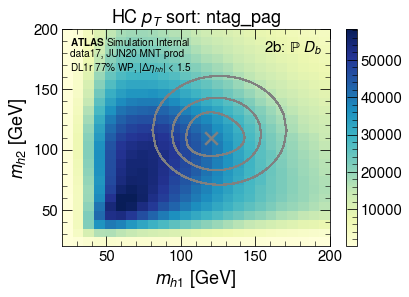

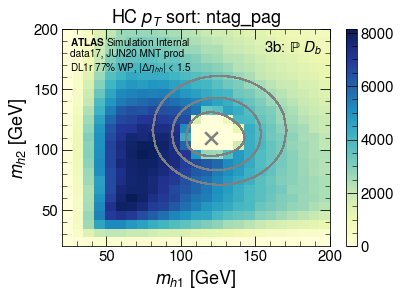

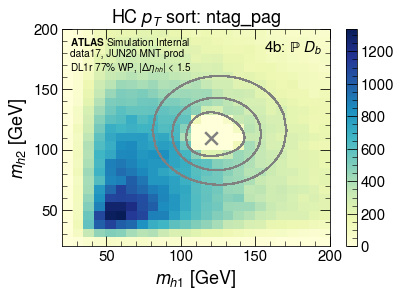

In [17]:
for ntag in [2,3,4]:

    # Caluclate the massplane
    mask = (dat_bkg.ntag_pag==ntag) & (dat_bkg.abs_deta_hh < 1.5)
    if ntag > 2: mask = mask & (dat_bkg.kr_new != 0)
    
    hist2d,_,_ = histogram2d(dat_bkg.loc[mask,'m_lead'], dat_bkg.loc[mask,'m_subl'],nb,rs)

    h2d = hist2d.compute()
    
    fig = plt.figure(figsize=(6,4))

    img = plt.imshow(h2d.T,origin='lower',cmap='YlGnBu',extent=[20, 200, 20, 200],aspect='auto')

    plt.colorbar(img)

    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    # Overlay our region definitions
    plt.scatter([x0],[y0],160,marker='x',color=c0)
    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    ax = plt.gca()
    plt.text(.97,.95,f'{ntag}b: {title}', transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,preXwt,transform=ax.transAxes,ha='left',va='top',fontsize=10)

    plt.title('HC $p_T$ sort: ntag_pag')

    plt.savefig(f'{bFigDir}/massplane_{ntag}b_HCsort.pdf',bbox_inches='tight')
    

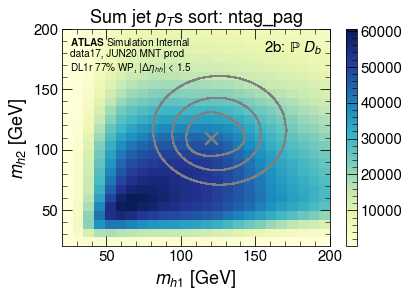

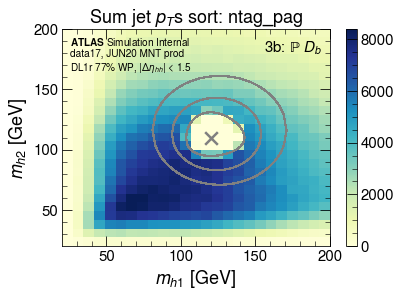

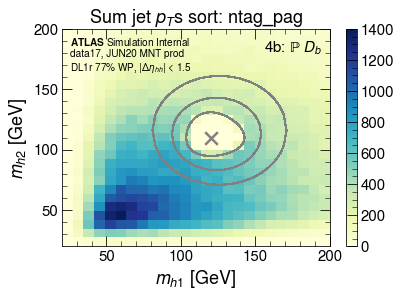

In [18]:
for ntag in [2,3,4]:

    # Caluclate the massplane
    mask = (dat_bkg.ntag_pag==ntag) & (dat_bkg.abs_deta_hh < 1.5)
    if ntag > 2: mask = mask & (dat_bkg.kinematic_region != 0)
    
    hist2d, ex, ey = histogram2d(dat_bkg.loc[mask,'m_h1'], dat_bkg.loc[mask,'m_h2'], nb,rs)

    h2d = hist2d.compute()
    
    fig = plt.figure(figsize=(6,4))

    img = plt.imshow(h2d.T,origin='lower',cmap='YlGnBu',extent=[20, 200, 20, 200],aspect='auto')

    plt.colorbar(img)

    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    # Overlay our region definitions
    plt.scatter([x0],[y0],160,marker='x',color=c0)
    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    ax = plt.gca()
    plt.text(.97,.95,f'{ntag}b: {title}', transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,preXwt,transform=ax.transAxes,ha='left',va='top',fontsize=10)

    plt.title('Sum jet $p_T$s sort: ntag_pag')

    plt.savefig(f'{bFigDir}/massplane_{ntag}b_jetPtSort.pdf',bbox_inches='tight')
    

In [17]:
hcSort = pd.DataFrame(0,index=['2b','3b','4b'],columns=['CR','VR','SR'])

for ntag in [2,3,4]:
    for r,region in zip([2,1,0],['CR','VR','SR']):
        
        if (r==0) and (ntag>2): continue
        
        mask = (dat_bkg.ntag_pag==ntag) & (dat_bkg.abs_deta_hh < 1.5) & (dat_bkg.kr_new == r)
        hcSort.loc[f'{ntag}b',region] = mask.sum().compute()

In [18]:
jptSort = pd.DataFrame(0,index=['2b','3b','4b'],columns=['CR','VR','SR'])

for ntag in [2,3,4]:
    for r,region in zip([2,1,0],['CR','VR','SR']):
        
        if (r==0) and (ntag>2): continue
        
        mask = (dat_bkg.ntag_pag==ntag) & (dat_bkg.abs_deta_hh < 1.5) & (dat_bkg.kinematic_region == r)
        jptSort.loc[f'{ntag}b',region] = mask.sum().compute()

In [20]:
hcSort / jptSort

CR        VR        SR
2b  0.948510  0.935370  0.924627
3b  0.949439  0.938240       NaN
4b  0.953850  0.944094       NaN

**Compare background distributions w/ the 2 sorts**

In [18]:
dat_bkg.head()

m_hh        m_h1        m_h2       pT_h1       pT_h2  ntag_pag  \
entry                                                                         
12     520.816137   52.754915   57.739198  230.524565  225.763168         2   
22     338.797452  135.221238  131.262234   65.135803   47.227345         2   
26     486.509210  262.067525   48.613395  182.182984  151.828544         2   
31     450.340308   46.539463   61.955473  141.780943  136.920718         2   
35     924.331052  516.012974  105.313143  269.222542  237.871706         2   

       kinematic_region  abs_deta_hh      m_lead      m_subl  Xhh_ptSort  \
entry                                                                      
12                    3     1.349408   52.754915   57.739198   15.633367   
22                    1     2.008934  135.221238  131.262234    1.972547   
26                    3     0.772111  262.067525   48.613395   13.741962   
31                    3     2.045074   46.539463   61.955473   17.586580   
35                    3     1.599800  516.012974  105.313143    7.687370   

       kr_new  
entry          
12        3.0  
22        1.0  
26        3.0  
31        3.0  
35        3.0

In [10]:
x1,y1 = 124, 116.5

dat_bkg = dat_bkg.map_partitions(lambda df: df.assign(Xhh_pt_new=getXhh(df.m_lead,df.m_subl,x1,y1)))

mask = (dat_bkg.abs_deta_hh<1.5) & ((dat_bkg.kinematic_region<3) | (dat_bkg.kr_new<3)) & (dat_bkg.ntag_pag>=2)
bdf = dat_bkg.loc[mask].compute()

In [11]:
psymb = '$\mathrm{\mathbb{P}}$'

CR: 4b pt
CR: 2b pt
VR: 4b pt
VR: 2b pt
SR: 4b pt
SR: 2b pt


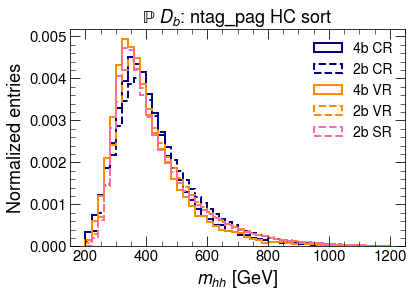

CR: 4b SS
CR: 2b SS
VR: 4b SS
VR: 2b SS
SR: 4b SS
SR: 2b SS


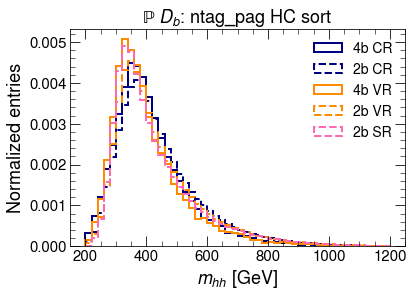

In [23]:
pag_hists = {}

for k, region, c in zip([2,1,0],['CR','VR','SR'],['navy','darkorange','hotpink']):

    for ntag,ls in zip([4,2],['-','--']):

        key = f'{region}: {ntag}b pt'
        print(key)
        if (k == 0) and (ntag == 4): continue

        # Calculate the histograms
        m = (bdf.kr_new == k) & (bdf.ntag_pag == ntag)
        ws,e,_ = plt.hist(bdf.loc[m,'m_hh'],50,(200,1200),color=c,histtype='step',
                          density=True,lw=2,ls=ls,label=f'{ntag}b {region}')
            
        pag_hists[key] = ws
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(fontsize=14)#,loc='center right')
plt.title(f'{psymb} $D_b$: ntag_pag HC sort')

plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_2b_4b_ntag_pag_regions_hcSort.pdf')
plt.show()


for k, region, c in zip([2,1,0],['CR','VR','SR'],['navy','darkorange','hotpink']):

    for ntag,ls in zip([4,2],['-','--']):

        key = f'{region}: {ntag}b SS'
        print(key)
        if (k == 0) and (ntag == 4): continue

        # Calculate the histograms
        m = (bdf.kinematic_region == k) & (bdf.ntag_pag == ntag)
        ws,e,_ = plt.hist(bdf.loc[m,'m_hh'],50,(200,1200),color=c,histtype='step',
                          density=True,lw=2,ls=ls,label=f'{ntag}b {region}')
        
        pag_hists[key] = ws
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(fontsize=14)
plt.title(f'{psymb} $D_b$: ntag_pag HC sort')

#plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_2b_4b_ntag_pag_regions_hcSort.pdf')
plt.show()


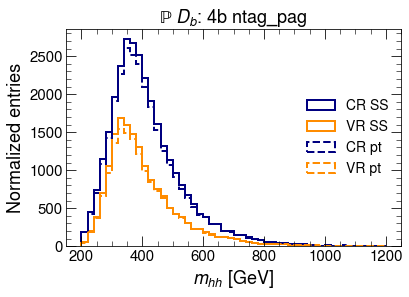

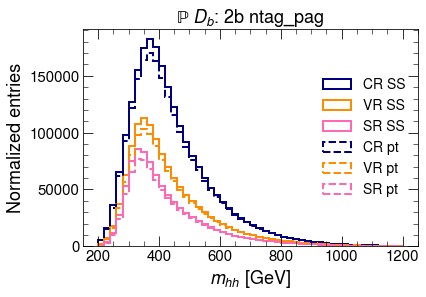

In [21]:
ttl_hists = {}

for ntag in [4,2]:

    plt.figure()

    for s, col,ls in zip(['SS','pt'],['kinematic_region','kr_new'],['-','--']):
    
        for k, region, c in zip([2,1,0],['CR','VR','SR'],['navy','darkorange','hotpink']):

            key = f'{region}: {ntag}b {s}'
            #print(key)
            if (k == 0) and (ntag == 4): continue

            # Calculate the histograms
            m = (bdf[col] == k) & (bdf.ntag_pag == ntag)
            ws,e,_ = plt.hist(bdf.loc[m,'m_hh'],50,(200,1200),color=c,histtype='step',
                              lw=2,ls=ls,label=f'{region} {s}')

            ttl_hists[key] = ws

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Normalized entries',fontsize=18)
    plt.legend(loc='center right')
    plt.title(f'{psymb} $D_b$: {ntag}b ntag_pag')


    #plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_2b_4b_ntag_pag_regions_hcSort.pdf')
    plt.show()



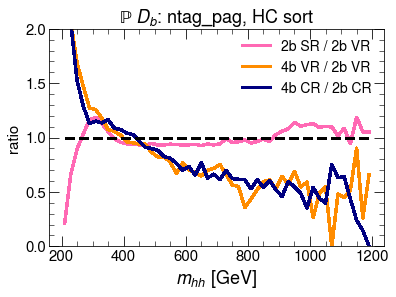

In [24]:
xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx, pag_hists['SR: 2b pt'] / pag_hists['VR: 2b pt'], 
         'hotpink',label='2b SR / 2b VR')
plt.plot(xx, pag_hists['VR: 4b pt'] / pag_hists['VR: 2b pt'], 
         'darkorange',label='4b VR / 2b VR')
plt.plot(xx, pag_hists['CR: 4b pt'] / pag_hists['CR: 2b pt'], 
         'navy',label='4b CR / 2b CR')

plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0,2)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio')
plt.title(f'{psymb} $D_b$: ntag_pag, HC sort')
plt.legend(bbox_to_anchor=(1,1.01))

plt.savefig(f'figures/{bSubDir}/preLN_lr_0p003/m_hh_ratio_options_hcSort.pdf')




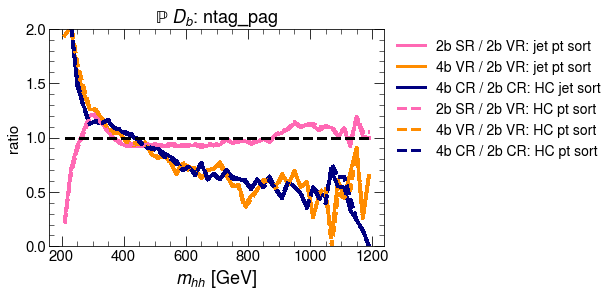

In [25]:
xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx, pag_hists['SR: 2b SS'] / pag_hists['VR: 2b SS'], 
         'hotpink',label='2b SR / 2b VR: jet pt sort')
plt.plot(xx, pag_hists['VR: 4b SS'] / pag_hists['VR: 2b SS'], 
         'darkorange',label='4b VR / 2b VR: jet pt sort')
plt.plot(xx, pag_hists['CR: 4b SS'] / pag_hists['CR: 2b SS'], 
         'navy',label='4b CR / 2b CR: HC jet sort')


plt.plot(xx, pag_hists['SR: 2b pt'] / pag_hists['VR: 2b pt'], 
         'hotpink',ls='--',label='2b SR / 2b VR: HC pt sort')
plt.plot(xx, pag_hists['VR: 4b pt'] / pag_hists['VR: 2b pt'], 
         'darkorange',ls='--',label='4b VR / 2b VR: HC pt sort')
plt.plot(xx, pag_hists['CR: 4b pt'] / pag_hists['CR: 2b pt'], 
         'navy',ls='--',label='4b CR / 2b CR: HC pt sort')

plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0,2)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio')
plt.title(f'{psymb} $D_b$: ntag_pag')
plt.legend(bbox_to_anchor=(1,1.01))

plt.savefig(f'figures/{bSubDir}/preLN_lr_0p003/m_hh_ratio_options_bothSorts.pdf')



/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


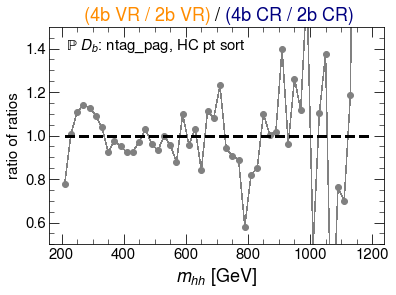

In [33]:
rw_pt_VR = pag_hists['VR: 4b pt'] / pag_hists['VR: 2b pt']
rw_pt_CR = pag_hists['CR: 4b pt'] / pag_hists['CR: 2b pt']
rw_ss_CR = pag_hists['CR: 4b SS'] / pag_hists['CR: 2b SS']

plt.plot(xx, rw_pt_VR / rw_pt_CR, 'grey',marker='o',lw=0.5)
plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0.5,1.5)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio of ratios')
ax = plt.gca()
plt.text(.05,.95,f'{psymb} $D_b$: ntag_pag, HC pt sort',ha='left',va='top',transform=ax.transAxes)

plt.title('       (4b VR / 2b VR)',loc='left',color='darkorange')
plt.title('/')
plt.title('(4b CR / 2b CR)      ',loc='right',color='navy')

plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_r_VR_by_r_CR_hcSort.pdf')

In [33]:
x1,y1

(124, 116.5)

**Next load in the signals**

In [12]:
# Load in the pag files
physicsSample = 'SMNR'
mc='mc16d'
sdf = pd.read_parquet(f'../data/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/df_{pconfig}_3b_Db_sort.parquet')

In [13]:
sdf = redoSort(sdf)
sdf['Xhh_pt_new'] = getXhh(sdf.m_lead, sdf.m_subl, x1,y1)
sdf['Xhh_ss_new'] = getXhh(sdf.m_h1, sdf.m_h2, x1,y1)

**Next:** Significance plot!!

In [14]:
bdf['Xhh_pt_new'] = getXhh(bdf.m_lead,bdf.m_subl,x1,y1)
bdf['Xhh_ss_new'] = getXhh(bdf.m_h1,bdf.m_h2,x1,y1)

(0.000381200121308558, 10000.0)

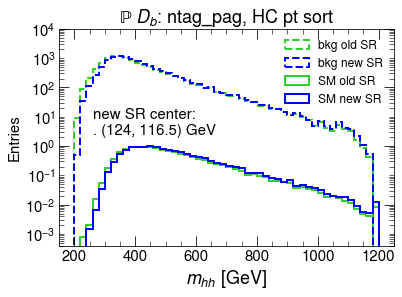

In [34]:
nb, r = 50,(200,1200)

n_SR,e = np.histogram(bdf.loc[(bdf.kr_new==0) & (bdf.ntag_pag == 2),'m_hh'],nb,r)
new_SR = np.histogram(bdf.loc[(bdf.Xhh_pt_new < 1.6) & (bdf.ntag_pag == 2),'m_hh'],nb,r)[0]

alpha = np.sum((bdf.kinematic_region==2) & (bdf.ntag_pag == 4)) / np.sum((bdf.kinematic_region==2) & (bdf.ntag_pag == 2))

c0, c1 = 'limegreen', 'b'

xx = 0.5 * (e[1:] + e[:-1])
plt.hist(xx,nb,r,histtype='step',color=c0,lw=2,label='bkg old SR',
         ls='--',weights=n_SR * alpha * rw_pt_CR)
plt.hist(xx,nb,r,histtype='step',color=c1,lw=2,label='bkg new SR',
         ls='--',weights=new_SR * alpha * rw_pt_CR)

# Next: overlay the signals
smask = (sdf.ntag_pag ==4) & (sdf.abs_deta_hh < 1.5)

s_old,_,_ = plt.hist(sdf.loc[smask & (sdf.kr_new==0),'m_hh'],
                     nb,r,histtype='step',color=c0,lw=2,label='SM old SR',
                     weights=sdf.loc[smask & (sdf.kr_new==0),'mc_sf'])
s_new,_,_ = plt.hist(sdf.loc[smask & (sdf.Xhh_pt_new<1.6),'m_hh'],
                     nb,r,histtype='step',color=c1,lw=2,label='SM new SR',
                     weights=sdf.loc[smask & (sdf.Xhh_pt_new<1.6),'mc_sf'])


plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries')
plt.title(f'{psymb} $D_b$: ntag_pag, HC pt sort')
plt.legend(fontsize=12)

ax = plt.gca()
plt.text(.1,.5,f'new SR center:\n. ({x1}, {y1}) GeV',
         transform=ax.transAxes,ha='left',va='bottom')

ax.set_yscale('log')

y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 8)
ax.yaxis.set_major_locator(y_major)

y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)

ylim = plt.ylim()
plt.ylim(ylim[0],1e4)


Text(0.5, 0.98, '4b ntag_pag, HC pt sort')

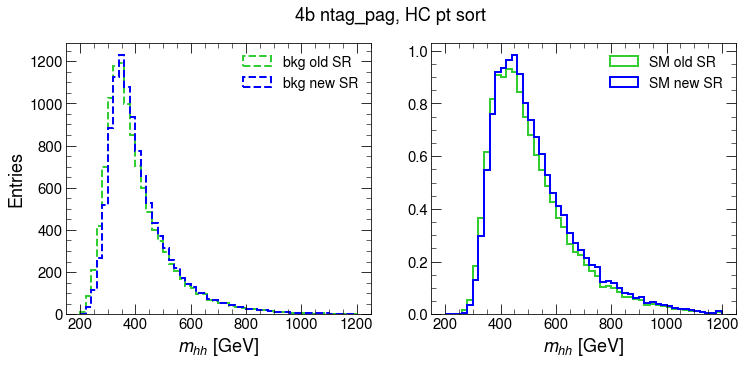

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

ax1.hist(xx,nb,r,histtype='step',color=c0,lw=2,label='bkg old SR',
         ls='--',weights=n_SR * alpha * rw_pt_CR)
ax1.hist(xx,nb,r,histtype='step',color=c1,lw=2,label='bkg new SR',
         ls='--',weights=new_SR * alpha * rw_pt_CR)

# Next: overlay the signals
smask = (sdf.ntag_pag ==4) & (sdf.abs_deta_hh < 1.5)

ax2.hist(sdf.loc[smask & (sdf.kr_new==0),'m_hh'],
                     nb,r,histtype='step',color=c0,lw=2,label='SM old SR',
                     weights=sdf.loc[smask & (sdf.kr_new==0),'mc_sf'])
ax2.hist(sdf.loc[smask & (sdf.Xhh_pt_new<1.6),'m_hh'],
                     nb,r,histtype='step',color=c1,lw=2,label='SM new SR',
                     weights=sdf.loc[smask & (sdf.Xhh_pt_new<1.6),'mc_sf'])

for ax in ax1, ax2:
    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    ax.legend()

ax1.set_ylabel('Entries',fontsize=18)

fig.suptitle('4b ntag_pag, HC pt sort')



/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square


old inf
new inf


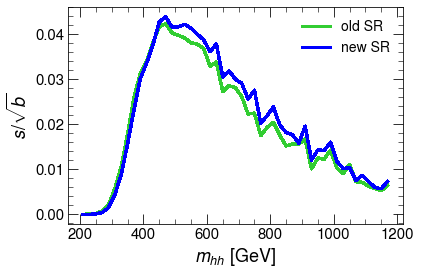

In [36]:
'''
Look at s / sqrt(b)
'''
y_old = s_old / np.sqrt(n_SR   * alpha * rw_pt_CR)
y_new = s_new / np.sqrt(new_SR * alpha * rw_pt_CR)

plt.figure()
plt.plot(xx,y_old,color=c0,label='old SR')
plt.plot(xx,y_new,color=c1,label='new SR')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('$s / \sqrt{b}$',fontsize=18)

plt.legend()

zold = np.sqrt(np.sum(np.nan_to_num(y_old)**2))
znew = np.sqrt(np.sum(np.nan_to_num(y_new)**2))
print('old',zold)
print('new',znew)

fig.suptitle('4b ntag_pag, HC pt sort')

plt.show()

In [48]:
znew / zold

1.0588360887102186

(0.5, 1.5)

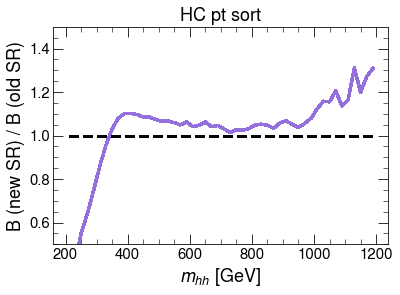

In [37]:
'''
Ratio on bkgs
'''

plt.figure()
plt.plot(xx, new_SR /  n_SR,color='mediumpurple')

plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('B (new SR) / B (old SR)',fontsize=18)

plt.plot(xx,np.ones_like(xx),'k--')

plt.title('HC pt sort')

plt.ylim(0.5,1.5)

**For background, I think there are actually 4 curves that I want to c.f:**

1. With the scalar sum jet $p_T$, the two SR centers
2. With the HC $p_T$, the 2 SR centers

In [9]:
for c in bdf.columns:
    print(c)

m_hh
m_h1
m_h2
pT_h1
pT_h2
ntag_pag
kinematic_region
Xhh
X_wt
abs_deta_hh
m_lead
m_subl
Xhh_ptSort
kr_new


In [10]:
# xs = np.linspace(115,118,4)
# ys = np.linspace(122,126,5)

# for x,y in product(xs,ys):
#     #print(x,y)
#     # For the HC pt sort
#     bdf[f'Xhh_pt_{x:.0f}_{y:.0f}'] = getXhh(bdf.m_lead,bdf.m_subl,x,y)
#     sdf[f'Xhh_pt_{x:.0f}_{y:.0f}'] = getXhh(sdf.m_lead,sdf.m_subl,x,y)
    
#     # For the sum jpt sort
#     bdf[f'Xhh_ss_{x:.0f}_{y:.0f}'] = getXhh(bdf.m_h1,bdf.m_h2,x,y)
#     sdf[f'Xhh_ss_{x:.0f}_{y:.0f}'] = getXhh(sdf.m_h1,sdf.m_h2,x,y)

In [13]:
x1, y1

(124, 116.5)

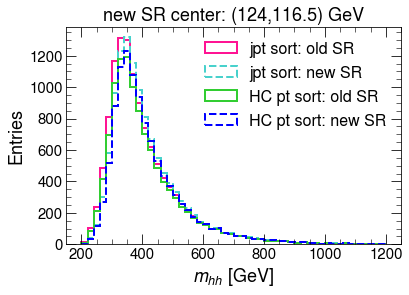

In [38]:
# Didn't reopt the CR - so it's the same alpha for both casees
alpha = np.sum((bdf.kinematic_region==2) & (bdf.ntag_pag == 4)) / np.sum((bdf.kinematic_region==2) & (bdf.ntag_pag == 2))

# jet pt sort  
bdf['Xhh_ss_new'] = getXhh(bdf.m_h1,bdf.m_h2,x1,y1)
n_ss_SR,e = np.histogram(bdf.loc[(bdf.kinematic_region==0) & (bdf.ntag_pag == 2),'m_hh'],nb,r)
new_ss_SR = np.histogram(bdf.loc[(bdf.Xhh_ss_new < 1.6) & (bdf.ntag_pag == 2),'m_hh'],nb,r)[0]

# HC pt sort      
n_SR,e = np.histogram(bdf.loc[(bdf.kr_new==0) & (bdf.ntag_pag == 2),'m_hh'],nb,r)
new_SR = np.histogram(bdf.loc[(bdf.Xhh_pt_new < 1.6) & (bdf.ntag_pag == 2),'m_hh'],nb,r)[0]


for n, c, ls, l in zip([n_ss_SR * rw_ss_CR, new_ss_SR * rw_ss_CR, n_SR * rw_pt_CR, new_SR * rw_pt_CR],
                               ['deeppink','mediumturquoise','limegreen','b'],
                               ['-','--']*2,
                               ['jpt sort: old SR','jpt sort: new SR','HC pt sort: old SR','HC pt sort: new SR']):

    plt.hist(xx,nb,r,histtype='step',ls=ls,color=c,label=l,weights=n*alpha,lw=2)
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(f'new SR center: ({x1},{y1}) GeV')
plt.legend(fontsize=16)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(0.5, 1.5)

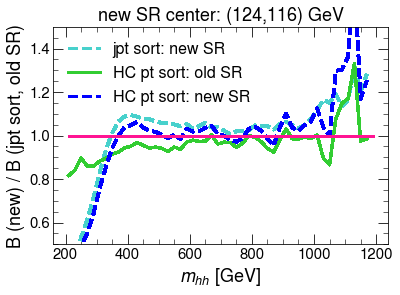

In [39]:
'''
Ratio on bkgs
'''
for n, c, ls, l in zip([new_ss_SR * rw_ss_CR, n_SR * rw_pt_CR, new_SR * rw_pt_CR],
                       ['mediumturquoise','limegreen','b'], ['--','-','--'],
                       ['jpt sort: new SR','HC pt sort: old SR','HC pt sort: new SR']):
    
    plt.plot(xx, n /  (n_ss_SR * rw_ss_CR), color=c,ls=ls,label=l)


plt.plot(xx,np.ones_like(xx),'deeppink')



plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('B (new) / B (jpt sort, old SR)',fontsize=18)
plt.title(f'new SR center: ({x1:.0f},{y1:.0f}) GeV')
plt.legend(fontsize=16)

plt.ylim(0.5,1.5)

**Next:** Scan over the SR radius.

In [40]:
Xhhs = np.arange(1,2.5,.1)

z_dict = {}
ntag = 'ntag_pag'
#for bdf,sdf,key,ntag in zip([bdf],[sdf],['Db','dR1'],['ntag_pag','ntag']):

alpha_pt = np.sum((bdf.kr_new==2) & (bdf[ntag] >= 4)) / np.sum((bdf.kr_new==2) & (bdf[ntag] == 2))
alpha_ss = np.sum((bdf.kinematic_region==2) & (bdf[ntag] >= 4)) / \
           np.sum((bdf.kinematic_region==2) & (bdf[ntag] == 2))

smask = (sdf[ntag] >=4) & (sdf.abs_deta_hh < 1.5)

z0,z1,z2,z3 = [],[],[],[]

s_sr0,s_sr1,s_sr2,s_sr3 = [],[],[],[]
b_sr0,b_sr1,b_sr2,b_sr3 = [],[],[],[]

s_vr0,s_vr1,s_vr2,s_vr3 = [],[],[],[]
b_vr0,b_vr1,b_vr2,b_vr3 = [],[],[],[]

for Xhh_cut in Xhhs:

    '''
    HC pt sort
    '''
    
    # Old SR
    n_SR = np.histogram(bdf.loc[(bdf.Xhh_ptSort<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b = n_SR * alpha_pt * rw_pt_CR

    s = np.histogram(sdf.loc[smask & (sdf.Xhh_ptSort<Xhh_cut),'m_hh'],nb,r,
                     weights=sdf.loc[smask & (sdf.Xhh_ptSort<Xhh_cut),'mc_sf'])[0]


    z = s / np.sqrt(b)
    #print(z)
    z0.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr0.append(s.sum())
    b_sr0.append(b.sum())
    
    s_vr0.append(np.sum(sdf.loc[smask & (sdf.kr_new<2) & (sdf.Xhh_ptSort>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdf.loc[(bdf.kr_new <2) & (bdf.Xhh_ptSort>Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * alpha_pt * rw_pt_CR
    b_vr0.append(np.sum(b_vr))
    
    # New SR
    new_SR = np.histogram(bdf.loc[(bdf.Xhh_pt_new<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]

    b = new_SR * alpha_pt * rw_pt_CR

    s = np.histogram(sdf.loc[smask & (sdf.Xhh_pt_new<Xhh_cut),'m_hh'],nb,r,
                     weights=sdf.loc[smask & (sdf.Xhh_pt_new<Xhh_cut),'mc_sf'])[0]

    z = np.nan_to_num(s / np.sqrt(b))
    z1.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr1.append(s.sum())
    b_sr1.append(b.sum())
    
    s_vr1.append(np.sum(sdf.loc[smask & (sdf.kr_new<2) & (sdf.Xhh_pt_new>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdf.loc[(bdf.kr_new <2) & (bdf.Xhh_pt_new>Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * alpha_pt * rw_pt_CR
    b_vr1.append(np.sum(b_vr))
    
    
    '''
    Sum jet pt sort
    '''
    # Old SR
    n_SR = np.histogram(bdf.loc[(bdf.Xhh<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b = n_SR * alpha_ss * rw_ss_CR

    s = np.histogram(sdf.loc[smask & (sdf.Xhh<Xhh_cut),'m_hh'],nb,r,
                     weights=sdf.loc[smask & (sdf.Xhh<Xhh_cut),'mc_sf'])[0]


    z = s / np.sqrt(b)
    z2.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr2.append(s.sum())
    b_sr2.append(b.sum())
    
    s_vr2.append(np.sum(sdf.loc[smask & (sdf.kinematic_region<2) & (sdf.Xhh>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdf.loc[(bdf.kinematic_region <2) & (bdf.Xhh>Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * alpha_ss * rw_ss_CR
    b_vr2.append(np.sum(b_vr))
    
    # New SR
    new_SR = np.histogram(bdf.loc[(bdf.Xhh_ss_new<Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]

    b = new_SR * alpha_ss * rw_ss_CR

    s = np.histogram(sdf.loc[smask & (sdf.Xhh_ss_new<Xhh_cut),'m_hh'],nb,r,
                     weights=sdf.loc[smask & (sdf.Xhh_ss_new<Xhh_cut),'mc_sf'])[0]

    z = np.nan_to_num(s / np.sqrt(b))
    z3.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr3.append(s.sum())
    b_sr3.append(b.sum())
    
    s_vr3.append(np.sum(sdf.loc[smask & (sdf.kinematic_region<2) & (sdf.Xhh_ss_new>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdf.loc[(bdf.kinematic_region <2) & (bdf.Xhh_ss_new>Xhh_cut) & (bdf[ntag] == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * alpha_ss * rw_ss_CR
    b_vr3.append(np.sum(b_vr))
    
s_sr0,s_sr1,s_sr2,s_sr3 = np.array(s_sr0),np.array(s_sr1),np.array(s_sr2),np.array(s_sr3)
b_sr0,b_sr1,b_sr2,b_sr3 = np.array(b_sr0),np.array(b_sr1),np.array(b_sr2),np.array(b_sr3)

s_vr0,s_vr1,s_vr2,s_vr3 = np.array(s_vr0),np.array(s_vr1),np.array(s_vr2),np.array(s_vr3)
b_vr0,b_vr1,b_vr2,b_vr3 = np.array(b_vr0),np.array(b_vr1),np.array(b_vr2),np.array(b_vr3)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:

In [48]:
len(Xhhs)

15

In [49]:
len(z0)

30

(0.12289968801203217, 0.17669277616598544)

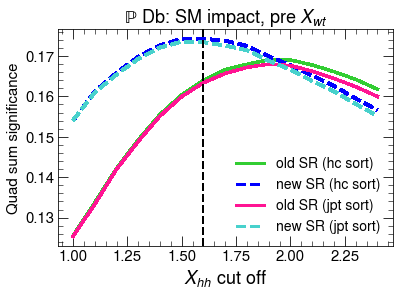

In [41]:
plt.plot(Xhhs,z0,c0,label=f'old SR (hc sort)')
plt.plot(Xhhs,z1,c1,label=f'new SR (hc sort)',ls='--')

plt.plot(Xhhs,z2,'deeppink',label=f'old SR (jpt sort)')
plt.plot(Xhhs,z3,'mediumturquoise',label=f'new SR (jpt sort)',ls='--')
 
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel('Quad sum significance')
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend()

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--',lw=2)
plt.ylim(ylim)
#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

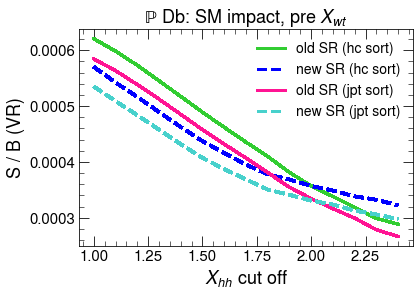

In [42]:
plt.plot(Xhhs,s_vr0/ b_vr0,c0,label=f'old SR (hc sort)')
plt.plot(Xhhs,s_vr1/ b_vr1,c1,label=f'new SR (hc sort)',ls='--')

plt.plot(Xhhs,s_vr2/ b_vr2,'deeppink',label=f'old SR (jpt sort)')
plt.plot(Xhhs,s_vr3/ b_vr3,'mediumturquoise',label=f'new SR (jpt sort)',ls='--')

plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel('S / B (VR)',fontsize=18)
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend()

#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

(0.000709858978857518, 0.0017173644277576289)

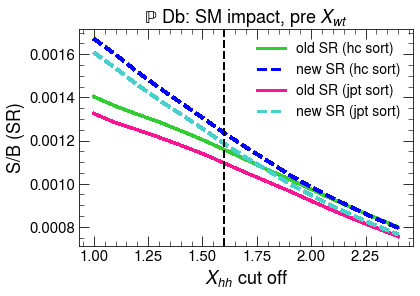

In [43]:
for s_sr,b_sr,s_vr,b_vr,c,ls,l in zip([s_sr0,s_sr1,s_sr2,s_sr3],
                                      [b_sr0,b_sr1,b_sr2,b_sr3],
                                      [s_vr0,s_vr1,s_vr2,s_vr3],
                                      [b_vr0,b_vr1,b_vr2,b_vr3],
                                      ['limegreen','b','deeppink','mediumturquoise'],
                                      ['-','--','-','--'],
                                      ['old SR (hc sort)','new SR (hc sort)','old SR (jpt sort)','new SR (jpt sort)']):

    plt.plot(Xhhs,(s_sr/b_sr),c,label=l,ls=ls)
    
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel('S/B (SR)',fontsize=18)
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend()

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--',lw=2)
plt.ylim(ylim)

#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

(0.31845043069359175, 0.4481530883163475)

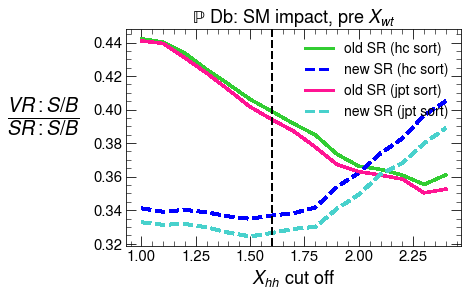

In [44]:
for s_sr,b_sr,s_vr,b_vr,c,ls,l in zip([s_sr0,s_sr1,s_sr2,s_sr3],
                                      [b_sr0,b_sr1,b_sr2,b_sr3],
                                      [s_vr0,s_vr1,s_vr2,s_vr3],
                                      [b_vr0,b_vr1,b_vr2,b_vr3],
                                      ['limegreen','b','deeppink','mediumturquoise'],
                                      ['-','--','-','--'],
                                      ['old SR (hc sort)','new SR (hc sort)','old SR (jpt sort)','new SR (jpt sort)']):

    plt.plot(Xhhs,(s_vr/b_vr) / (s_sr/b_sr),c,label=l,ls=ls)
    
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel(r'$\frac{VR: S / B}{SR: S/B}$',fontsize=28,rotation=0,labelpad=50)
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend()

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--',lw=2)
plt.ylim(ylim)

#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

And now with min(dR1) as well...

In [15]:
rcols = ['m_hh','m_h1','m_h2', 'ntag', 'kinematic_region', 'Xhh', 'X_wt','j3_Db']

# Open the dfs
dat_dR1 = dd.read_parquet(f'../data/data17-JUN20/files/df_min_dR1_?b_Db_sort_period?_00*.parquet',
                          columns=rcols+['abs_deta_hh'])

bdr = dat_dR1.loc[(dat_dR1.abs_deta_hh < 1.5) & (dat_dR1.kinematic_region<=2),rcols].compute()

sdr = sdR = pd.read_parquet('../data/SMNR_mc16d-JUN20/df_min_dR1_3b_Db_sort.parquet',
                            columns=rcols+['abs_deta_hh','mc_sf'])

In [16]:
bdr['Xhh_new'] = getXhh(bdr.m_h1, bdr.m_h2, x1,y1)
sdr['Xhh_new'] = getXhh(sdr.m_h1, sdr.m_h2, x1,y1)

In [47]:
smask = (sdr.ntag >=4) & (sdr.abs_deta_hh < 1.5)

z4,z5 = [],[]

s_sr4,s_sr5 = [],[]
b_sr4,b_sr5 = [],[]
s_vr4,s_vr5 = [],[]
b_vr4,b_vr5 = [],[]

n_CR_4b = np.histogram(bdr.loc[(bdr.kinematic_region==2) & (bdr.ntag>=4),'m_hh'],nb,r)[0]
n_CR_2b = np.histogram(bdr.loc[(bdr.kinematic_region==2) & (bdr.ntag==2),'m_hh'],nb,r)[0]
rw_CR_dr = n_CR_4b / n_CR_2b

for Xhh_cut in Xhhs:

    
    # Old SR
    n_SR = np.histogram(bdr.loc[(bdr.Xhh<Xhh_cut) & (bdr.ntag == 2),'m_hh'],nb,r)[0]
    b = n_SR * rw_CR_dr

    s = np.histogram(sdr.loc[smask & (sdr.Xhh<Xhh_cut),'m_hh'],nb,r,
                     weights=sdr.loc[smask & (sdr.Xhh<Xhh_cut),'mc_sf'])[0]


    z = s / np.sqrt(b)
    z4.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr4.append(s.sum())
    b_sr4.append(b.sum())
    
    s_vr4.append(np.sum(sdf.loc[smask & (sdr.kinematic_region<2) & (sdr.Xhh>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdr.loc[(bdr.kinematic_region <2) & (bdr.Xhh>Xhh_cut) & (bdr.ntag == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * rw_CR_dr
    b_vr4.append(np.sum(b_vr))
    
    # New SR
    new_SR = np.histogram(bdr.loc[(bdr.Xhh_new<Xhh_cut) & (bdr.ntag == 2),'m_hh'],nb,r)[0]

    b = new_SR * rw_CR_dr

    s = np.histogram(sdr.loc[smask & (sdr.Xhh_new<Xhh_cut),'m_hh'],nb,r,
                     weights=sdr.loc[smask & (sdr.Xhh_new<Xhh_cut),'mc_sf'])[0]

    z = np.nan_to_num(s / np.sqrt(b))
    z5.append( np.sqrt(np.sum((z[1:-1])**2)) )

    # Calc the VR contamination
    s_sr5.append(s.sum())
    b_sr5.append(b.sum())
    
    s_vr5.append(np.sum(sdr.loc[smask & (sdr.kinematic_region<2) & (sdr.Xhh_new>Xhh_cut),'mc_sf']))
    
    n_VR = np.histogram(bdr.loc[(bdr.kinematic_region <2) & (bdr.Xhh_new>Xhh_cut) & (bdr.ntag == 2),'m_hh'],nb,r)[0]
    b_vr = n_VR * rw_CR_dr
    b_vr5.append(np.sum(b_vr))
    

s_sr4,s_sr5 = np.array(s_sr4),np.array(s_sr5)
b_sr4,b_sr5 = np.array(b_sr4),np.array(b_sr5)
s_vr4,s_vr5 = np.array(s_vr4),np.array(s_vr5)
b_vr4,b_vr5 = np.array(b_vr4),np.array(b_vr5)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


(0.12289566475629324, 0.17677726453650322)

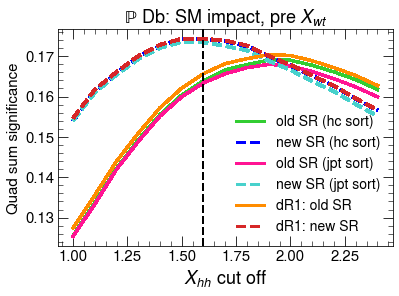

In [48]:
plt.plot(Xhhs,z0,c0,label=f'old SR (hc sort)')
plt.plot(Xhhs,z1,c1,label=f'new SR (hc sort)',ls='--')

plt.plot(Xhhs,z2,'deeppink',label=f'old SR (jpt sort)')
plt.plot(Xhhs,z3,'mediumturquoise',label=f'new SR (jpt sort)',ls='--')

plt.plot(Xhhs,z4,'darkorange',label=f'dR1: old SR')
plt.plot(Xhhs,z5,'C3',label=f'dR1: new SR',ls='--')
 
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel('Quad sum significance')
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend()

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--',lw=2)
plt.ylim(ylim)
#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

(0.31845043069359175, 0.4481530883163475)

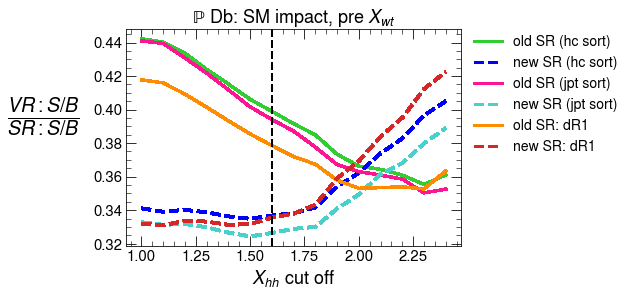

In [49]:
for s_sr,b_sr,s_vr,b_vr,c,ls,l in zip([s_sr0,s_sr1,s_sr2,s_sr3,s_sr4,s_sr5],
                                      [b_sr0,b_sr1,b_sr2,b_sr3,b_sr4,b_sr5],
                                      [s_vr0,s_vr1,s_vr2,s_vr3,s_vr4,s_vr5],
                                      [b_vr0,b_vr1,b_vr2,b_vr3,b_vr4,b_vr5],
                                      ['limegreen','b','deeppink','mediumturquoise','darkorange','C3'],
                                      ['-','--']*3,
                                      ['old SR (hc sort)','new SR (hc sort)','old SR (jpt sort)','new SR (jpt sort)',
                                       'old SR: dR1','new SR: dR1']):

    plt.plot(Xhhs,(s_vr/b_vr) / (s_sr/b_sr),c,label=l,ls=ls)
    
plt.xlabel('$X_{hh}$ cut off',fontsize=18)
plt.ylabel(r'$\frac{VR: S / B}{SR: S/B}$',fontsize=28,rotation=0,labelpad=50)
plt.title(f'{psymb} Db: '+'SM impact, pre $X_{wt}$')
plt.legend(bbox_to_anchor=(1,1.03))

ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k--',lw=2)
plt.ylim(ylim)

#plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

Ok - in terms of these metrics, pag and min(dR1) are quite similar.

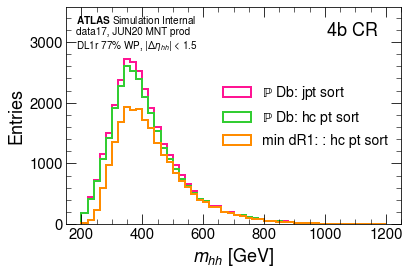

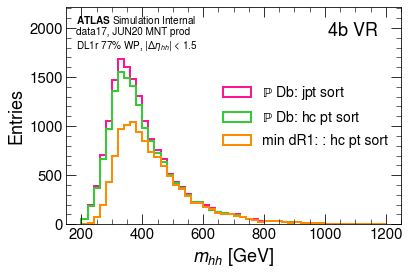

In [50]:
for k,region in zip([2,1],['CR','VR']):
    
    plt.figure()
    
    # pag, jpt sort
    plt.hist(bdf.loc[(bdf.ntag_pag == 4) & (bdf.kinematic_region==k),'m_hh'],
             nb,r,histtype='step',lw=2,
             label=f'{psymb} Db: jpt sort',color='deeppink')

    plt.hist(bdf.loc[(bdf.ntag_pag == 4) & (bdf.kr_new==k),'m_hh'],
             nb,r,histtype='step',lw=2,
             label=f'{psymb} Db: hc pt sort',color=c0)
    
    # min dr
    plt.hist(bdr.loc[(bdr.ntag >= 4) & (bdr.kinematic_region==k),'m_hh'],nb,r,histtype='step',lw=2,
             label='min dR1: : hc pt sort',color='darkorange')
                
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=14,loc='center right')
    
    ax = plt.gca()
    plt.text(0.03,0.97,preXwt,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    plt.text(.93,.93,f'4b {region}',transform=ax.transAxes,ha='right',va='top',fontsize=18)
    
    _,ymax = plt.ylim()
    plt.ylim(0,1.25*ymax)
    
    #plt.savefig(f'{figDir}/m_hh_4b_{region}_ntag_vs_ntag_pag.pdf',bbox_inches='tight')
    

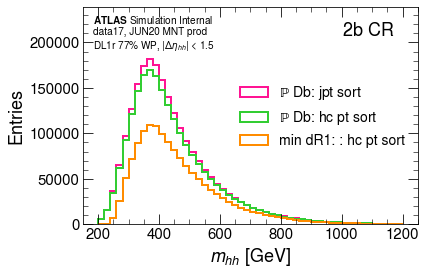

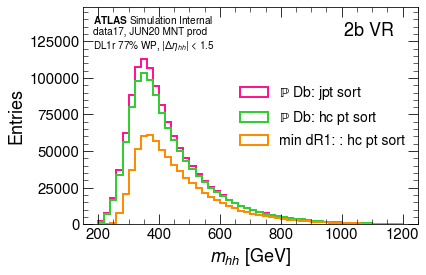

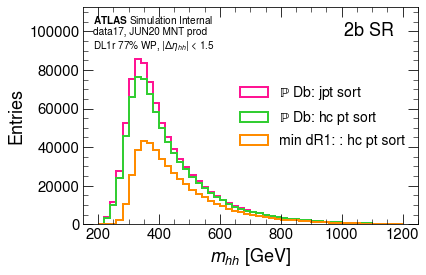

In [129]:

for k,region in zip([2,1,0],['CR','VR','SR']):
    
    plt.figure()
    
    # pag, jpt sort
    plt.hist(bdf.loc[(bdf.ntag_pag == 2) & (bdf.kinematic_region==k),'m_hh'],
             nb,r,histtype='step',lw=2,
             label=f'{psymb} Db: jpt sort',color='deeppink')

    plt.hist(bdf.loc[(bdf.ntag_pag == 2) & (bdf.kr_new==k),'m_hh'],
             nb,r,histtype='step',lw=2,
             label=f'{psymb} Db: hc pt sort',color=c0)
    
    # min dr
    plt.hist(bdr.loc[(bdr.ntag == 2) & (bdr.kinematic_region==k),'m_hh'],nb,r,histtype='step',lw=2,
             label='min dR1: : hc pt sort',color='darkorange')
                
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(fontsize=14,loc='center right')
    
    ax = plt.gca()
    plt.text(0.03,0.97,preXwt,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    plt.text(.93,.93,f'2b {region}',transform=ax.transAxes,ha='right',va='top',fontsize=18)
    
    _,ymax = plt.ylim()
    plt.ylim(0,1.25*ymax)
    
    #plt.savefig(f'{figDir}/m_hh_4b_{region}_ntag_vs_ntag_pag.pdf',bbox_inches='tight')
    

Ok - this is *great*, but I think I need a **3d** scan for the opt SR center $(x',y')$ + the Xhh cutoff

(Maybe it's better to wait for full bkg estimates for this level of detail?)

## Next: Let's rinse + repeat for the 3b categories

**Open Q:** What is the extra gain from these 2 categories for pag vs $\min \Delta R_{jj}^{HC1}$?

**Step 1:** Is my $m_{hh}$ correction factor valid for these other 2 cateogries too????

In [138]:
bdf.columns

Index(['m_hh', 'm_h1', 'm_h2', 'pT_h1', 'pT_h2', 'ntag_pag',
       'kinematic_region', 'Xhh', 'X_wt', 'abs_deta_hh', 'm_lead', 'm_subl',
       'Xhh_ptSort', 'kr_new', 'Xhh_ss_new', 'Xhh_new', 'Xhh_pt_new'],
      dtype='object')

CR: 3b + 1 loose pt
CR: 3b not loose pt
VR: 3b + 1 loose pt
VR: 3b not loose pt


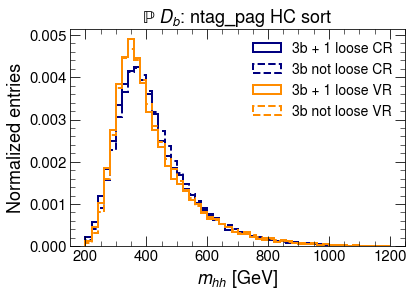

CR: 3b SS
CR: 3b SS
VR: 3b SS
VR: 3b SS


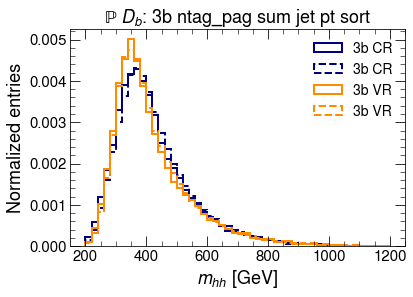

In [52]:
ntag=3

for k, region, c in zip([2,1],['CR','VR'],['navy','darkorange']):

    for minQ, tag, ls in zip([2,1],['+ 1 loose','not loose'],['-','--']):

        key = f'{region}: {ntag}b {tag} pt'
        print(key)
        if (k == 0) and (ntag == 4): continue

        # Calculate the histograms
        m = (bdf.kr_new == k) & (bdf.ntag_pag == ntag) & (bdf.minQ == minQ)
        ws,e,_ = plt.hist(bdf.loc[m,'m_hh'],50,(200,1200),color=c,histtype='step',
                          density=True,lw=2,ls=ls,label=f'{ntag}b {tag} {region}')
            
        pag_hists[key] = ws
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(fontsize=14)#,loc='center right')
plt.title(f'{psymb} $D_b$: ntag_pag HC sort')

#plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_3b_cats_ntag_pag_regions_hcSort.pdf')
plt.show()


for k, region, c in zip([2,1],['CR','VR'],['navy','darkorange']):

    for minQ, tag, ls in zip([2,1],['+ 1 loose','not loose'],['-','--']):

        key = f'{region}: {ntag}b SS'
        print(key)
        if (k == 0) and (ntag == 4): continue

        # Calculate the histograms
        m = (bdf.kinematic_region == k) & (bdf.ntag_pag == ntag) & (bdf.minQ == minQ)
        ws,e,_ = plt.hist(bdf.loc[m,'m_hh'],50,(200,1200),color=c,histtype='step',
                          density=True,lw=2,ls=ls,label=f'{ntag}b {region}')
        
        pag_hists[key] = ws
        
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(fontsize=14)
plt.title(f'{psymb} $D_b$: 3b ntag_pag sum jet pt sort')

#plt.savefig(f'figures/{bSubDir}/{pconfig}/m_hh_3b_cats_ntag_pag_regions.pdf')
plt.show()



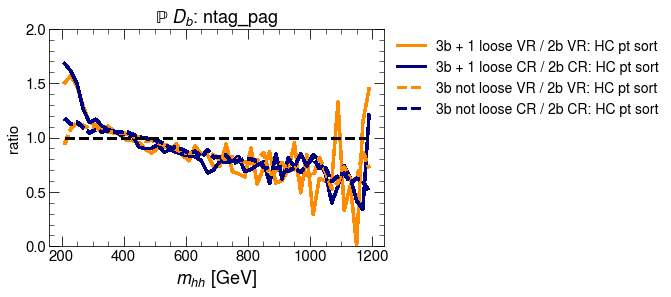

In [54]:
plt.plot(xx, pag_hists['VR: 3b + 1 loose pt'] / pag_hists['VR: 2b pt'], 
         'darkorange',label='3b + 1 loose VR / 2b VR: HC pt sort')
plt.plot(xx, pag_hists['CR: 3b + 1 loose pt'] / pag_hists['CR: 2b pt'], 
         'navy',label='3b + 1 loose CR / 2b CR: HC pt sort')


plt.plot(xx, pag_hists['VR: 3b not loose pt'] / pag_hists['VR: 2b pt'], 
         'darkorange',ls='--',label='3b not loose VR / 2b VR: HC pt sort')
plt.plot(xx, pag_hists['CR: 3b not loose pt'] / pag_hists['CR: 2b pt'], 
         'navy',ls='--',label='3b not loose CR / 2b CR: HC pt sort')

plt.plot(xx,np.ones_like(xx),'k--')

plt.ylim(0,2)
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('ratio')
plt.title(f'{psymb} $D_b$: ntag_pag')
plt.legend(bbox_to_anchor=(1,1.01))

#plt.savefig(f'figures/{bSubDir}/preLN_lr_0p003/m_hh_ratio_options_bothSorts.pdf')

Interesting that 3b + 1 loose has a slightly *softer* $m_{hh}$ spectrum, anticipated b/c the $b$-tagging  efficiency goes increases as jet $p_T$ increases.


Just to keep it simple, I think that I'm going to only look at the HC sort rn.


In [62]:
sdf['minQ'] = sdf[['Db_h1_j1','Db_h1_j2','Db_h2_j1','Db_h2_j2']].values.min(axis=1)

In [18]:
'minQ' in sdf.columns

True

In [20]:
nb,r = 50,(200,1200)

In [28]:
bdr['j3_Db'] = dat_dR1.loc[(dat_dR1.abs_deta_hh < 1.5) & (dat_dR1.kinematic_region<=2),'j3_Db'].compute()

In [29]:
for sdi,bdi,pid,ntag,c,kr,Xold,Xnew in zip([sdf,sdr], [bdf,bdr], ['pag','dR1'], ['ntag_pag','ntag'],
                                           ['minQ','j3_Db'],['kr_new','kinematic_region'],
                                           ['Xhh_ptSort','Xhh'],['Xhh_pt_new','Xhh_new']):


    for minQ in [2,1]:

          
        smask = (sdi[ntag] ==3) & (sdi[c]==minQ) & (sdi.abs_deta_hh < 1.5)

        # Get the rw correction factor
        target = np.histogram(bdi.loc[(bdi[kr]==2) & (bdi[ntag]==3) & (bdi[c]==minQ),'m_hh'],nb,r)[0]
        source = np.histogram(bdi.loc[(bdi[kr]==2) & (bdi[ntag]==2),'m_hh'],nb,r)[0]
        rw_corr = target / source

        
        key = f'{pid}_Q{minQ}'
        z_dict[f'{key}_old'] = []
        z_dict[f'{key}_new'] = []
        print(key,c)
    
        for Xhh_cut in Xhhs:

            # Old SR
            n_SR = np.histogram(bdi.loc[(bdi[Xold]<Xhh_cut) & (bdi[ntag] == 2),'m_hh'],nb,r)[0]
            b = n_SR * rw_corr

            s = np.histogram(sdi.loc[smask & (sdi[Xold]<Xhh_cut),'m_hh'],nb,r,
                             weights=sdi.loc[smask & (sdi[Xold]<Xhh_cut),'mc_sf'])[0]

            z = s / np.sqrt(b)

            z_dict[key+'_old'].append( np.sqrt(np.sum((z[1:-1])**2)) )

            
            # New SR
            new_SR = np.histogram(bdi.loc[(bdi[Xnew]<Xhh_cut) & (bdi[ntag] == 2),'m_hh'],nb,r)[0]

            b = new_SR * rw_corr

            s = np.histogram(sdi.loc[smask & (sdi[Xnew]<Xhh_cut),'m_hh'],nb,r,
                             weights=sdi.loc[smask & (sdi[Xnew]<Xhh_cut),'mc_sf'])[0]

            z = np.nan_to_num(s / np.sqrt(b))
            z_dict[key+'_new'].append( np.sqrt(np.sum((z[1:-1])**2)) )



pag_Q2 minQ


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


pag_Q1 minQ
dR1_Q2 j3_Db


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


dR1_Q1 j3_Db


In [22]:
key

'pag_Q1'

In [31]:
c0,c1 = 'limegreen','b'

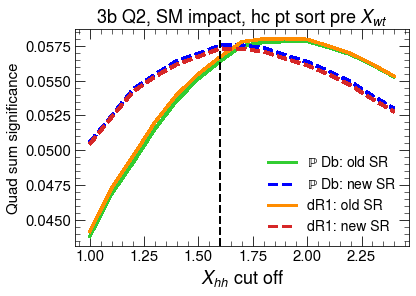

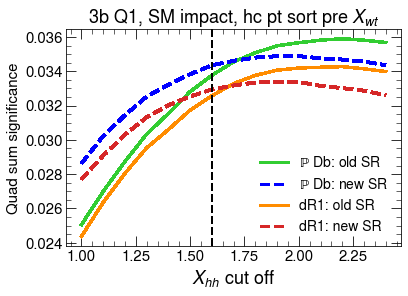

In [35]:
for minQ in [2,1]:

    plt.figure()
    plt.plot(Xhhs,z_dict[f'pag_Q{minQ}_old'],c0,label=f'{psymb} Db: old SR')
    plt.plot(Xhhs,z_dict[f'pag_Q{minQ}_new'],c1,label=f'{psymb} Db: new SR',ls='--')

    # plt.plot(Xhhs,z2,'deeppink',label=f'old SR (jpt sort)')
    # plt.plot(Xhhs,z3,'mediumturquoise',label=f'new SR (jpt sort)',ls='--')

    plt.plot(Xhhs,z_dict[f'dR1_Q{minQ}_old'],'darkorange',label=f'dR1: old SR')
    plt.plot(Xhhs,z_dict[f'dR1_Q{minQ}_new'],'C3',label=f'dR1: new SR',ls='--')

    plt.xlabel('$X_{hh}$ cut off',fontsize=18)
    plt.ylabel('Quad sum significance')
    plt.title(f'3b Q{minQ}, '+'SM impact, hc pt sort pre $X_{wt}$')
    plt.legend()

    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k--',lw=2)
    plt.ylim(ylim)
    #plt.savefig(f'{figDir}/Xhh_scan_preXwt.pdf',bbox_inches='tight')

Yeah - ok, need to do some more work optimizing the SR center, but really the take away message here is it isn't looking like tightening the SR is going to have a massive impact.

I *was* delighted that the 3b not loose was *almost* as impactful as 3b + loose tho.

In [37]:
Xhhs[6]

1.6000000000000005

In [39]:
z0 = .174 # 4b alone

np.sqrt(np.sum(z0**2 + z_dict['pag_Q2_new'][6]**2)) / z0

1.0532553704852992

In [40]:
np.sqrt(np.sum(z0**2 + z_dict['pag_Q2_new'][6]**2 + z_dict['pag_Q1_new'][6]**2)) / z0

1.071601607302618

Let's start off using the same newly opt SR center